<a href="https://colab.research.google.com/github/lakshmanpadigala/SMAI_S22_5/blob/main/randomerase_svhn_mean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pdb
import argparse
import numpy as np
from tqdm import tqdm
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
# import matplotlib as plt
from torchvision.utils import make_grid
from torchvision import datasets, transforms
import math
import time

In [2]:
class RandomErasing(object):
    def __init__(self, EPSILON = 0.5, sl = 0.02, sh = 0.4, r1 = 0.3, mean=[0.4914, 0.4822, 0.4465]):
        self.EPSILON = EPSILON
        self.mean = mean
        self.sl = sl
        self.sh = sh
        self.r1 = r1
       
    def __call__(self, img):
        if random.uniform(0, 1) > self.EPSILON:
#             print("Returning same image")
            return img

        for attempt in range(100):
            area = img.size()[1] * img.size()[2]
       
            target_area = random.uniform(self.sl, self.sh) * area
            aspect_ratio = random.uniform(self.r1, 1/self.r1)

            h = int(round(math.sqrt(target_area * aspect_ratio)))
            w = int(round(math.sqrt(target_area / aspect_ratio)))
            
            if w < img.size()[2] and h < img.size()[1]:
                
                x1 = random.randint(0, img.size()[1] - h)
                y1 = random.randint(0, img.size()[2] - w)
                if img.size()[0] == 3:
#                     print("Height:",h,"Width:",w)
#                     img[0, x1:x1+h, y1:y1+w] = random.uniform(0, 1)
#                     img[1, x1:x1+h, y1:y1+w] = random.uniform(0, 1)
#                     img[2, x1:x1+h, y1:y1+w] = random.uniform(0, 1)
                    img[0, x1:x1+h, y1:y1+w] = self.mean[0]
                    img[1, x1:x1+h, y1:y1+w] = self.mean[1]
                    img[2, x1:x1+h, y1:y1+w] = self.mean[2]
                    # img[:, x1:x1+h, y1:y1+w] = torch.from_numpy(np.random.rand(3, h, w))
                else:
                    # img[0, x1:x1+h, y1:y1+w] = self.mean[1]
                    img[0, x1:x1+h, y1:y1+w] = torch.from_numpy(np.random.rand(1, h, w))
                return img

        return img

In [3]:
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = conv3x3(3,64)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


In [5]:
normalize = transforms.Normalize(mean=[x / 255.0 for x in [109.9, 109.7, 113.8] ],std=[x / 255.0 for x in [50.1, 50.6, 50.8] ])
train_transform = transforms.Compose([])
train_transform.transforms.append(transforms.ToTensor())
train_transform.transforms.append(normalize)
train_transform.transforms.append(RandomErasing(mean=[x / 255.0 for x in [109.9, 109.7, 113.8] ]))
test_transform = transforms.Compose([transforms.ToTensor(),normalize])

In [6]:
train_dataset = datasets.SVHN(root='data/',
                                  split='train',
                                  transform=train_transform,
                                  download=True)
test_dataset = datasets.SVHN(root='data/',
                                 split='test',
                                 transform=test_transform,
                                 download=True)

  0%|          | 0/182040794 [00:00<?, ?it/s]

  0%|          | 0/64275384 [00:00<?, ?it/s]

In [7]:
train_dataset.data.shape, test_dataset.data.shape

((73257, 3, 32, 32), (26032, 3, 32, 32))

In [8]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=128,
                                           shuffle=True,
                                           pin_memory=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=128,
                                          shuffle=False,
                                          pin_memory=True,
                                          num_workers=2)

In [15]:
imgs = []
for i, (images, labels) in enumerate(train_loader):
    imgs.extend(images[0:6])
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


([], <a list of 0 Text major ticklabel objects>)

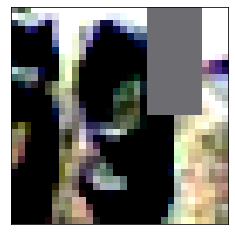

In [17]:
# img_normalized = transform_norm(img)
img_normalized = imgs[2]
  
# convert tis image to numpy array
img_normalized = np.array(img_normalized)
  
# transpose from shape of (3,,) to shape of (,,3)
img_normalized = img_normalized.transpose(1, 2, 0)
  
# display the normalized image
plt.imshow(img_normalized)
plt.xticks([])
plt.yticks([])

In [18]:
num_classes = 10
cnn = ResNet(BasicBlock, [2,2,2,2], num_classes)

In [ ]:
cnn.state_dict

<bound method Module.state_dict of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(6

In [19]:
cnn = cnn.cuda()
criterion = nn.CrossEntropyLoss().cuda()
cnn_optimizer = torch.optim.SGD(cnn.parameters(), lr=0.1,
                                momentum=0.9, nesterov=True, weight_decay=5e-4)
scheduler = MultiStepLR(cnn_optimizer, milestones=[80, 120], gamma=0.1)

In [20]:
def test(loader):
    cnn.eval()    # Change model to 'eval' mode (BN uses moving mean/var).
    correct = 0.
    total = 0.
    for images, labels in loader:
        images = images.cuda()
        labels = labels.cuda()

        with torch.no_grad():
            pred = cnn(images)

        pred = torch.max(pred.data, 1)[1]
        total += labels.size(0)
        correct += (pred == labels).sum().item()

    val_acc = correct / total
    cnn.train()
    return val_acc



In [21]:
train_accuracy = []
test_accuracy = []
entropy = []

In [ ]:
for epoch in range(200):

    xentropy_loss_avg = 0.
    correct = 0.
    total = 0.

    progress_bar = tqdm(train_loader)
    for i, (images, labels) in enumerate(progress_bar):
        progress_bar.set_description('Epoch ' + str(epoch))

        images = images.cuda()
        labels = labels.cuda()

        cnn.zero_grad()
        pred = cnn(images)

        xentropy_loss = criterion(pred, labels)
        xentropy_loss.backward()
        cnn_optimizer.step()

        xentropy_loss_avg += xentropy_loss.item()

        pred = torch.max(pred.data, 1)[1]
        total += labels.size(0)
        correct += (pred == labels.data).sum().item()
        accuracy = correct / total

        progress_bar.set_postfix(
            xentropy='%.3f' % (xentropy_loss_avg / (i + 1)),
            acc='%.3f' % accuracy)

    test_acc = test(test_loader)
    tqdm.write('test_acc: %.3f' % (test_acc))

    scheduler.step()

    # row = {'epoch': str(epoch), 'train_acc': str(accuracy), 'test_acc': str(test_acc)}
    train_accuracy.append(accuracy)
    test_accuracy.append(test_acc)
    entropy.append(xentropy_loss_avg / (i + 1))

Epoch 0: 100%|██████████| 573/573 [03:42<00:00,  2.58it/s, acc=0.187, xentropy=2.291]
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


test_acc: 0.227


Epoch 1: 100%|██████████| 573/573 [03:38<00:00,  2.63it/s, acc=0.621, xentropy=1.113]


test_acc: 0.854


Epoch 2: 100%|██████████| 573/573 [03:43<00:00,  2.57it/s, acc=0.835, xentropy=0.509]


test_acc: 0.917


Epoch 3: 100%|██████████| 573/573 [03:36<00:00,  2.65it/s, acc=0.862, xentropy=0.427]


test_acc: 0.909


Epoch 4: 100%|██████████| 573/573 [03:43<00:00,  2.56it/s, acc=0.875, xentropy=0.391]


test_acc: 0.918


Epoch 5: 100%|██████████| 573/573 [03:37<00:00,  2.63it/s, acc=0.883, xentropy=0.369]


test_acc: 0.929


Epoch 6: 100%|██████████| 573/573 [03:42<00:00,  2.57it/s, acc=0.883, xentropy=0.363]


test_acc: 0.927


Epoch 7: 100%|██████████| 573/573 [03:36<00:00,  2.65it/s, acc=0.888, xentropy=0.352]


test_acc: 0.939


Epoch 8: 100%|██████████| 573/573 [03:43<00:00,  2.56it/s, acc=0.891, xentropy=0.343]


test_acc: 0.931


Epoch 9: 100%|██████████| 573/573 [03:36<00:00,  2.64it/s, acc=0.890, xentropy=0.344]


test_acc: 0.928


Epoch 10: 100%|██████████| 573/573 [03:42<00:00,  2.58it/s, acc=0.893, xentropy=0.332]


test_acc: 0.928


Epoch 11: 100%|██████████| 573/573 [03:37<00:00,  2.63it/s, acc=0.895, xentropy=0.329]


test_acc: 0.931


Epoch 12: 100%|██████████| 573/573 [03:43<00:00,  2.56it/s, acc=0.896, xentropy=0.327]


test_acc: 0.915


Epoch 13: 100%|██████████| 573/573 [03:37<00:00,  2.64it/s, acc=0.897, xentropy=0.321]


test_acc: 0.927


Epoch 14: 100%|██████████| 573/573 [03:42<00:00,  2.58it/s, acc=0.898, xentropy=0.317]


test_acc: 0.939


Epoch 15: 100%|██████████| 573/573 [03:37<00:00,  2.63it/s, acc=0.900, xentropy=0.314]


test_acc: 0.920


Epoch 16: 100%|██████████| 573/573 [03:42<00:00,  2.58it/s, acc=0.900, xentropy=0.312]


test_acc: 0.934


Epoch 17: 100%|██████████| 573/573 [03:36<00:00,  2.65it/s, acc=0.901, xentropy=0.311]


test_acc: 0.928


Epoch 18: 100%|██████████| 573/573 [03:42<00:00,  2.57it/s, acc=0.903, xentropy=0.307]


test_acc: 0.937


Epoch 19: 100%|██████████| 573/573 [03:38<00:00,  2.62it/s, acc=0.901, xentropy=0.306]


test_acc: 0.933


Epoch 20:   5%|▍         | 28/573 [00:11<03:35,  2.53it/s, acc=0.905, xentropy=0.302]